# Rover.com Analytics Assessment
**Andrew Nicholls** | Email: andrew.s.nicholls@gmail.com | [Github](https://github.com/Booleans)

If you are viewing this notebook in Github you may want to switch to the nbviewer page to ensure interactive charts are functioning properly: https://nbviewer.jupyter.org/github/Booleans/rover-analytics-assessment/blob/master/analysis.ipynb

### Exercise Problems
Click the hyperlink to skip to the desired assessment section.

I. [Exploring the Database](#1)  
II. [Conversations and Bookings](#2)  
III. [Recent Daily Booking Rate](#3)   
IV. [Analyzing Take Rate](#4)   
V. [New Conversation Flow](#5)  
VI. [Search Engine Marketing](#6)

In [29]:
import pandas as pd
import numpy as np
import datetime 
import plotly.graph_objects as go
import plotly.express as px

## Loading and Reviewing Available Data
It's important to look at and understand our available data before attempting an analysis.

#### conversations_conversation

An owner can book a service provider by starting a conversation with them. This table stores a
record for each conversation started on our platform. Many of the fields on this table are self
explanatory but we have detailed a few below.

* `start_date` - This is the date for which pet care will first be needed.
* `end_date` - This is the last date for which pet care will be needed.
* `units` - This is the number of units of service that the owner is interested in booking.
* `added` - A timestamp for when this conversation was created.
* `booking_total` - This is the dollar amount (not including the owner’s service fee) that this
booking would cost.
* `requester_id` - This foreign key reports the people_person record for the pet owner that is
requesting pet care.
* `service_id` - This foreign key reports the services_service record for the service that the
pet owner is requesting.
* `booked_at` - If the request is booked, this timestamp reports when that occurred.
* `cancelled_at` - A booked request can be cancelled. In that case, this timestamp reports
when that occurred.

In [3]:
df_conversations = pd.read_csv('data/conversations_conversation.csv', low_memory=False,
                               parse_dates=['added', 'start_date', 'end_date', 'booked_at','cancelled_at'])
print(f'Imported conversations_conversation.csv into df_conversations with shape: {df_conversations.shape}')
df_conversations.head()

Imported conversations_conversation.csv into df_conversations with shape: (80180, 11)


,id,start_date,end_date,units,added,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at
0,1,2018-07-26,2018-07-31,5,2018-07-16 10:17:53.460035,120,NaN,64393,4646,NaT,NaT
1,2,2018-08-10,2018-08-16,6,2018-08-01 10:20:48.626868,132,NaN,64392,10126,NaT,NaT
2,3,2018-06-16,2018-06-19,3,2018-06-05 16:46:39.542467,168,NaN,64391,20677,NaT,NaT
3,4,2018-07-13,2018-07-20,7,2018-07-02 09:12:22.275923,490,NaN,64391,3847,NaT,NaT
4,5,2018-07-02,2018-07-07,5,2018-06-21 16:02:48.694725,140,NaN,64389,9982,NaT,NaT


#### conversations_conversation_pets

Since a booking may involve many pets and many pets might have had many bookings, it is
necessary to store this many-to-many relationship on a separate table. Many of the fields on this
table are self explanatory but we have detailed a few below.

* `conversation_id` - A foreign key to a booking request on the conversations_converation
table. If this conversation involves caring for more than one pets, then this
conversation_id will occur on more than one row on this table (once for each pet).
* `pet_id` - A foreign key to a pet that will receive pet care during the corresponding
conversation’s booking.

In [4]:
df_conversations_pets = pd.read_csv('data/conversations_conversation_pets.csv', low_memory=False)
print(f'Imported conversations_conversation_pets.csv into df_conversations_pets with shape: {df_conversations_pets.shape}')
df_conversations_pets.head()

Imported conversations_conversation_pets.csv into df_conversations_pets with shape: (120188, 3)


,id,conversation_id,pet_id
0,1,1,77730
1,2,2,77729
2,3,3,77728
3,4,3,77727
4,5,4,77728


#### conversations_message

Each conversation consists of a series of messages. A conversation may contain many
messages, but not vice versa. Many of the fields on this table are self explanatory but we have
detailed a few below.
* `conversation_id` - This foreign key reports the conversation in
conversations_conversation for which this message is apart of.
* `sender_id` - This foreign key reports the user in people_person that sent this message.

In [5]:
df_conversations_message = pd.read_csv('data/conversations_message.csv', low_memory=False, parse_dates=['sent'])
print(f'Imported conversations_message.csv into df_conversations_message with shape: {df_conversations_message.shape}')
df_conversations_message.head()

Imported conversations_message.csv into df_conversations_message with shape: (401211, 5)


,id,sent,content,conversation_id,sender_id
0,1,2018-07-16 10:17:53.460035,Massa class.,1,64393
1,2,2018-07-28 16:53:53.927200,Porta lorem ornare condimentum.,1,2709
2,3,2018-07-16 23:55:22.904038,Neque curae rutrum elit conubia metus in.,1,2709
3,4,2018-07-23 10:05:49.829926,Donec etiam gravida luctus tellus phasellus ri...,1,2709
4,5,2018-08-01 10:20:48.626868,Risus class dui leo sem dui sed sollicitudin.,2,64392


#### conversations_review

If a booking occurs, then either participant can leave a review for the experience. This table
records those reviews, which consist of a brief statement and a star rating. Many of the fields on
this table are self explanatory but we have detailed a few below.
* `conversation_id` - This foreign key reports the booking in conversations_conversation for
which this review pertains.
* `reviewer_id` - This foreign key reports the user in people_person that wrote this review.

In [6]:
df_conversations_review = pd.read_csv('data/conversations_review.csv', low_memory=False)
print(f'Imported conversations_review.csv into df_conversations_review with shape: {df_conversations_review.shape}')
df_conversations_review.head()

Imported conversations_review.csv into df_conversations_review with shape: (28561, 5)


,id,content,stars,conversation_id,reviewer_id
0,1,Netus proin per duis dolor venenatis nam.,1,7,64386
1,2,Dolor proin donec phasellus ve suspendisse ac ...,5,9,64384
2,3,Proin ipsum urna nisl egestas justo class a ar...,5,11,64382
3,4,Porta velit lectus varius donec tellus sollici...,1,13,64381
4,5,Dolor felis.,2,15,64379


#### people_person

This table details each user on our site. This table may contain dog owners, dog sitters, or
people who have not transacted on our site. Many of the fields on this table are self explanatory
but we have detailed a few below.
* `channel` - This field reports how this user discovered our site when they signed up.
* `date_joined` - The timestamp for when this user signed up.
* `fee` - When a user books a service as a dog owner, we charge the owner a separate
service fee that takes the form of a percentage of the booking total.

In [7]:
df_people_person = pd.read_csv('data/people_person.csv', low_memory=False, parse_dates=['date_joined'])
print(f'Imported people_person.csv into df_people_person with shape: {df_people_person.shape}')
df_people_person.head()

Imported people_person.csv into df_people_person with shape: (64393, 9)


,id,first_name,last_name,email,channel,date_joined,photo,fee,gender
0,1,Leanora,Allcock,leanora.allcock635@hotmail.com,NaN,2016-08-02 14:59:15.095591,https://placekitten.com/242/269,0.0,f
1,2,Elroy,Blanding,elroy.blanding510@yahoo.com,NaN,2016-08-02 18:15:30.105940,https://placekitten.com/373/320,0.0,m
2,3,Jeanice,Aleman,jeanice.aleman392@hotmail.com,NaN,2016-08-02 16:11:09.542004,https://placekitten.com/238/264,0.0,f
3,4,Tamala,Polhamus,tamala.polhamus146@aol.com,NaN,2016-08-02 18:02:40.389299,https://placekitten.com/220/223,0.0,f
4,5,Alethea,Gubler,alethea.gubler708@aol.com,NaN,2016-08-02 14:31:53.163034,https://placekitten.com/284/339,0.0,f


#### people_testsegmentation

Occasionally, this company would run an A/B test which required that users get placed in two
groups. This table provides a log for experiments which require user-level segmentations. Many
of the fields on this table are self explanatory but we have detailed a few below.
* `person_id` - This foreign key reports the people_person record that was segmented.
* `test_name` - Multiple tests were run on this site and all are logged on this table. Use this
column to filter to the correct experiment.
* `test_group` - For the purposes of the experiment in test_name , the user given by
person_id was segmented into the group named in this column (e.g., holdout , variant , A
, B , etc.).
* `added` - The timestamp reporting the time when this user was segmented.

In [8]:
df_people_test = pd.read_csv('data/people_testsegmentation.csv', low_memory=False, parse_dates=['added'])
print(f'Imported people_testsegmentation.csv into df_people_test with shape: {df_people_test.shape}')
df_people_test.head()

Imported people_testsegmentation.csv into df_people_test with shape: (87778, 5)


,id,test_name,test_group,added,person_id
0,1,Email Test,holdout,2016-08-02 14:59:15.095591,1
1,2,Email Test,variant,2016-08-02 18:15:30.105940,2
2,3,Email Test,holdout,2016-08-02 16:11:09.542004,3
3,4,Email Test,holdout,2016-08-02 18:02:40.389299,4
4,5,Email Test,holdout,2016-08-02 14:31:53.163034,5


#### pets_pet

This table details each pet that a user has added to their profile. One owner may have more
than one pet, but not vice versa. Many of the fields on this table are self explanatory but we
have detailed a few below.
* `description` - A short (lorem ipsum) description of the pet.
* `plays_cats` - If 1, then this pet plays well with cats.
* `plays_children` - If 1, then this pet plays well with children.
* `plays_dogs` - If 1, then this pet plays well with dogs.
* `spayed_neutered` - If 1, then this pet has been spayed or neutered.
* `house_trained` - If 1, then this pet is house trained.
* `owner_id` - This foreign key reports the people_person record for this pet’s owner.

In [9]:
df_pets = pd.read_csv('data/pets_pet.csv', low_memory=False, parse_dates=['birthday'])
print(f'Imported pets_pet.csv into df_pets with shape: {df_pets.shape}')
df_pets.head()

Imported pets_pet.csv into df_pets with shape: (77730, 13)


,id,name,description,gender,weight,birthday,plays_cats,plays_children,plays_dogs,spayed_neutered,house_trained,size,owner_id
0,1,Jammie,Morbi fames a mauris elit malesuada platea.,f,76,2016-05-26,1,1,1,1,1,large,12601
1,2,Lonnie,Class magna a libero felis sociosqu.,f,12,2014-05-20,0,1,1,1,0,small,12602
2,3,Emely,Felis class.,m,11,2014-08-21,0,1,1,1,0,small,12602
3,4,Emelia,Fames class egestas mollis risus posuere.,f,35,2013-09-23,1,1,1,0,0,medium,12603
4,5,Jami,Netus augue a congue orci.,m,35,2014-05-13,0,1,1,1,1,medium,12603


#### services_service

On our site, users may offer pet care services. This table stores a record for each service that is
offered. Each user can offer more than one service, but not more than one of each type. Many
of the fields on this table are self explanatory but we have detailed a few below.
* `max_dogs` - This number is the maximum number of pets this provider would prefer to
care for.
* `fee` - When a user books with a service, we take a percentage of the booking total. This
field reports the percentage.
* `provider_id` - This foreign key reports the people_person record for this service’s
provider.
* `added` - A timestamp for when this service became active.
* `price` - The price per unit booked.

In [10]:
df_services = pd.read_csv('data/services_service.csv', low_memory=False, parse_dates=['added'])
print(f'Imported services_service.csv into df_services with shape: {df_services.shape}')
df_services.head()

Imported services_service.csv into df_services with shape: (21398, 16)


,id,service_type,cancellation_policy,can_provide_oral_medication,can_provide_injected_medication,senior_dog_experience,special_needs_experience,takes_small_dogs,takes_medium_dogs,takes_large_dogs,takes_puppies,max_dogs,provider_id,fee,price,added
0,1,boarding,strict,1,1,1,1,0,1,1,1,4,1,0.15,35,2016-08-02 14:59:15.095591
1,2,dog-walking,strict,1,0,1,1,0,0,1,1,5,1,0.15,26,2016-08-02 14:59:15.095591
2,3,boarding,moderate,0,0,1,0,0,0,1,1,2,2,0.15,31,2016-08-02 18:15:30.105940
3,4,dog-walking,strict,1,0,1,0,1,0,0,1,5,2,0.15,27,2016-08-02 18:15:30.105940
4,5,day-care,strict,1,0,1,1,0,1,1,1,5,2,0.15,30,2016-08-02 18:15:30.105940


**Normalizing Dates**


We only need to group the data by year, month, and day. The time component is not relevant for the questions in this assessment so we will remove it.

In [11]:
dataframes = [df_conversations, df_conversations_message, df_conversations_pets, df_conversations_review,
              df_people_person, df_people_test, df_pets, df_services]

for dataframe in dataframes:
    date_cols = dataframe.select_dtypes(include=['datetime64[ns]'])
    
    for col in date_cols:
        dataframe[col] = dataframe[col].dt.normalize()

<a id='1'></a>
## I. Exploring the Database
1. How many users have signed up?  
*The answer is 64393.*
2. How many users signed up prior to 2018-02-03?  
*The answer is 35826.*
3. What percentage of users have added pets?  
*The answer is 80.43%.*
4. Of those users, how many pets have they added on average?  
*The answer is 1.501.*
5. What percentage of pets play well with cats?  
*The answer is 24.85%.*

In [12]:
# 1. How many users have signed up?
df_people_person['id'].nunique()

64393

In [13]:
# 2. How many users signed up prior to 2018-02-03?
sum(df_people_person['date_joined'] < pd.Timestamp(2018,2,3))

35826

In [14]:
# 3. What percentage of users have added pets?
round(df_pets['owner_id'].nunique()/df_people_person['id'].nunique() * 100, 2)

80.43

In [15]:
# 4. Of those users, how many pets have they added on average?
round(len(df_pets)/df_pets['owner_id'].nunique(), 3)

1.501

In [16]:
# 5. What percentage of pets play well with cats?
round(df_pets['plays_cats'].sum()/len(df_pets) * 100, 2)

24.85

<a id='2'></a>
## II. Conversations and Bookings

Some users can offer pet care services. When an owner needs pet care, they can create a conversation with another user that offers the service they are interested in. After exchanging some messages and possibly meeting in person, that conversation hopefully books. In that case, services are paid for and delivered. Occasionally, some conversations that have booked may be cancelled. Lastly, for un-cancelled bookings, both owners and sitters have the option of leaving a review.  In the following questions, we explore these concepts.

1. For un-cancelled bookings, is the owner or provider more likely to leave a review and
which tends to leave better reviews? How would you narrate this finding to a business partner?

First, let's get all the uncancelled bookings.

In [17]:
mask = df_conversations['booked_at'].notnull() & df_conversations['cancelled_at'].isnull()
uncancelled_bookings = df_conversations.loc[mask, :]
uncancelled_bookings.head()

,id,start_date,end_date,units,added,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at
5,6,2018-07-04,2018-07-07,3,2018-06-23,78,NaN,64388,14772,2018-06-27,NaT
6,7,2018-07-31,2018-08-04,4,2018-07-21,100,NaN,64386,14783,2018-07-22,NaT
8,9,2018-07-02,2018-07-03,1,2018-06-21,23,NaN,64384,7656,2018-06-23,NaT
10,11,2018-06-12,2018-06-18,6,2018-06-03,300,NaN,64382,2512,2018-06-07,NaT
12,13,2018-07-24,2018-07-27,3,2018-07-13,126,NaN,64381,1634,2018-07-19,NaT


In [18]:
df_conversations_review.head()

,id,content,stars,conversation_id,reviewer_id
0,1,Netus proin per duis dolor venenatis nam.,1,7,64386
1,2,Dolor proin donec phasellus ve suspendisse ac ...,5,9,64384
2,3,Proin ipsum urna nisl egestas justo class a ar...,5,11,64382
3,4,Porta velit lectus varius donec tellus sollici...,1,13,64381
4,5,Dolor felis.,2,15,64379


We need to join the reviews to the uncancelled bookings. Once we do that we only need to keep requester_id, reviewer_id, and stars in order to determine the differences between owners and providers.

In [19]:
df_reviews = pd.merge(uncancelled_bookings, df_conversations_review,
                      left_on='id', right_on='conversation_id')[['requester_id', 'reviewer_id', 'stars']]
df_reviews.head()

,requester_id,reviewer_id,stars
0,64386,64386,1
1,64384,64384,5
2,64382,64382,5
3,64381,64381,1
4,64379,64379,2


If the person leaving the review is also the person who requested the service then we know it is an owner's review. 

In [20]:
df_reviews['reviewer_type'] = np.where(df_reviews['reviewer_id'] == df_reviews['requester_id'], 'owner', 'provider')
df_reviews.head(5)

,requester_id,reviewer_id,stars,reviewer_type
0,64386,64386,1,owner
1,64384,64384,5,owner
2,64382,64382,5,owner
3,64381,64381,1,owner
4,64379,64379,2,owner


In [21]:
df_reviews.groupby('reviewer_type', as_index = False).agg(['count', 'mean'])['stars']

,count,mean
reviewer_type,,
owner,22499,4.415841
provider,6062,3.904817


**Answer:**  

As we can see in the table above, pet owners are nearly 4 times as likely to leave a review compared to the providers. Pet owners also give higher average reviews of around 4.42 stars compared to 3.89 stars from providers. This is approximately half a star higher.

To narrate this finding to a business partner I would use the simple chart below to show the discrepancy between how often providers and owners leave reviews. To show the average rating, I would simply use the table in the cell above that shows the mean rating by reviewer type. This information can easily be communicated with text instead of a chart.

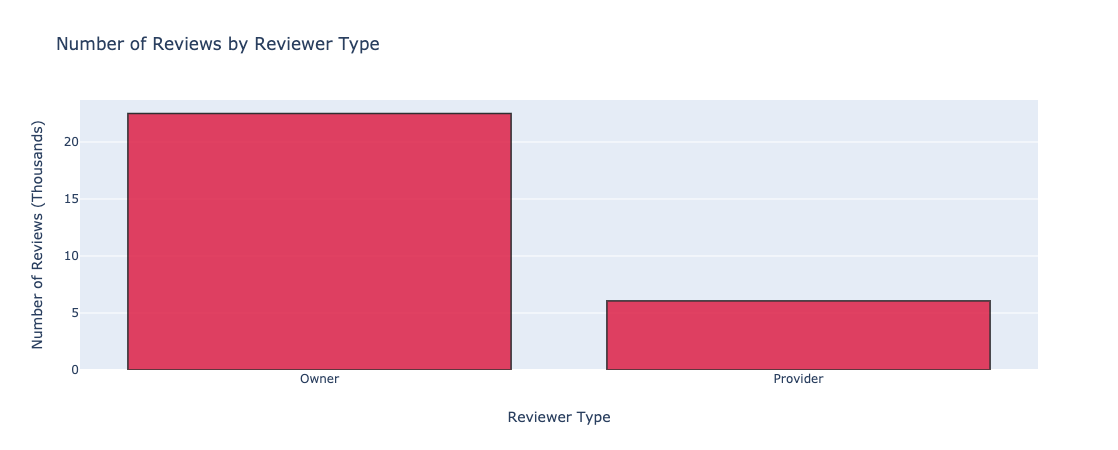

In [88]:
group_review_data = df_reviews.groupby('reviewer_type', as_index = False).agg(['count', 'mean'])['stars']['count']

x = [user_type.capitalize() for user_type in group_review_data.index]
y = group_review_data.values/1000

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=[f'{100*round(y[0]/sum(y),2)}% of Reviews', f'{100*round(y[1]/sum(y),2)}% of Reviews'])])
# Customize aspect
fig.update_traces(marker_color='crimson', marker_line_color='black',
                  marker_line_width=1.5, opacity=.8)
fig.update_layout(title_text='Number of Reviews by Reviewer Type', xaxis_title='Reviewer Type', yaxis_title='Number of Reviews (Thousands)',
                  yaxis_tickformat = 'digit')
fig.show()

<a id='3'></a>
## III. Recent Daily Booking Rate

The snapshot of this database was taken on 2018-08-02 at midnight and only contains data reflecting events prior to that date. A junior analyst is investigating daily booking rate during the days prior to the snapshot and is concerned about an apparent downward trend. You are tasked with helping them out.
1. First, let's reproduce their results. They tell you that daily booking rate is defined to be the percentage of conversations created each day that eventually book. What is the daily booking rate for each of the 90 days prior to the snapshot? Is there a downward trend?

2. Can you narrate a reason why this trend exists? Is there a reason to be concerned?

In [82]:
df_temp = df_conversations.loc[:, ['added', 'booked_at']]
df_temp.head()

,added,booked_at
0,2018-07-16,NaT
1,2018-08-01,NaT
2,2018-06-05,NaT
3,2018-07-02,NaT
4,2018-06-21,NaT


In [83]:
df_temp.loc[:, 'was_booked'] = df_temp['booked_at'].notnull().astype(int)
df_temp.head(5)

,added,booked_at,was_booked
0,2018-07-16,NaT,0
1,2018-08-01,NaT,0
2,2018-06-05,NaT,0
3,2018-07-02,NaT,0
4,2018-06-21,NaT,0


In [84]:
# We only need data from the previous 90 days.
# I'm using a static cutoff date for this problem but it could be made dynamic to update automatically when new data is available.
cutoff_date = pd.Timestamp(year=2018, month=5, day=3)
mask = df_temp['added'] > cutoff_date
df_temp = df_temp.loc[mask, :]
df_temp.head()

,added,booked_at,was_booked
0,2018-07-16,NaT,0
1,2018-08-01,NaT,0
2,2018-06-05,NaT,0
3,2018-07-02,NaT,0
4,2018-06-21,NaT,0


In [85]:
book_rate = df_temp[['added', 'was_booked']].groupby(['added'], as_index = False).agg(['mean']) * 100
book_rate.head()

,was_booked
,mean
added,
2018-05-04,44.700461
2018-05-05,44.690265
2018-05-06,44.782609
2018-05-07,48.543689
2018-05-08,40.707965


In [131]:
df_book_rate = book_rate['was_booked'].reset_index()
df_book_rate.rename(columns={'added':'date', 'mean':'rate'}, inplace=True)
df_book_rate.head()

,date,rate
0,2018-05-04,44.700461
1,2018-05-05,44.690265
2,2018-05-06,44.782609
3,2018-05-07,48.543689
4,2018-05-08,40.707965


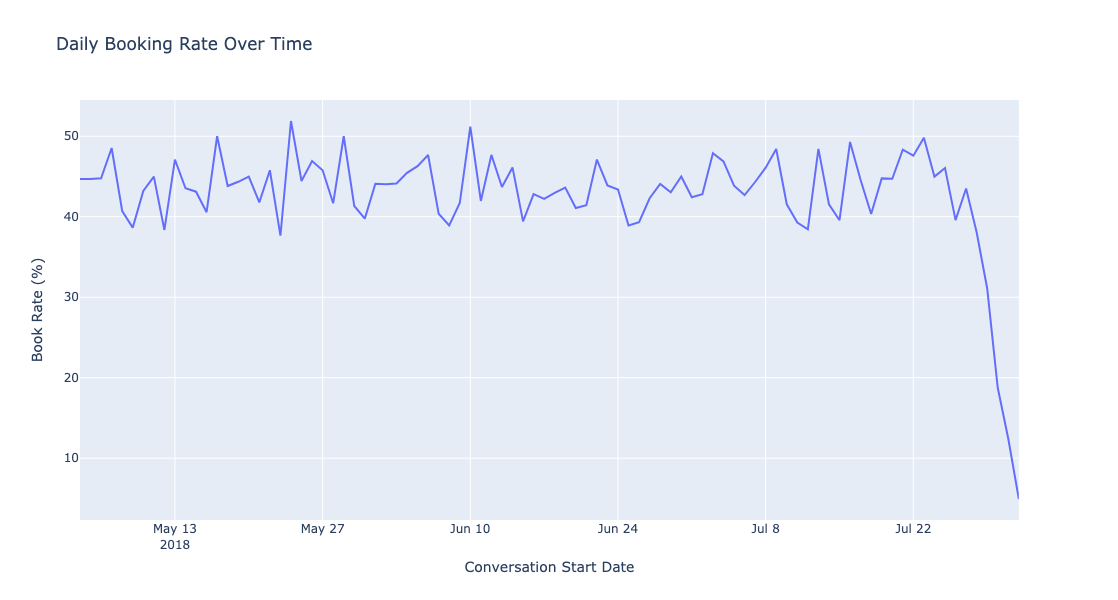

In [133]:
fig = px.line(df_book_rate, x='date', y='rate', title='Daily Booking Rate')
fig.update_layout(title='Daily Booking Rate Over Time',
                   xaxis_title='Conversation Start Date',
                   yaxis_title='Book Rate (%)')
fig.show()

**1. What is the daily booking rate for each of the 90 days prior to the snapshot? Is there a downward trend?**

I have created an interactive chart above that allows the user to hover a mouse over the data and see the book rate for each day. It tends to oscillate between 40 and 50 percent. There is a significant downward trend starting after July 27th, 2018.

**2. Can you narrate a reason why this trend exists? Is there a reason to be concerned? Please provide additional data and evidence to justify your position.**

I do not believe there is a reason to be concerned. Pet owners initiate conversations, but the provider does not have to accept the same day. Perhaps it takes a few days for providers to accept and that is why conversations near the end of the dataset do not contain as many confirmed bookings. As seen in the cell below, it takes an average of more than 3 days for a provider to accept a request from an owner. Therefore, I would not yet be concerned because the drop off occurs within the last few days of our data snapshot. Those conversations have been initiated but have not yet had enough time to book. 

In [ ]:
mask = df_temp['booked_at'].notnull()
bookings = df_temp.loc[mask, ['added', 'booked_at']]
bookings['days_to_book'] = (bookings['booked_at'] - bookings['added']).dt.days
mean_days_to_book = bookings['days_to_book'].mean()
print(f'It takes an average of {round(mean_days_to_book, 2)} days for a conversation to turn into a booking.')

<a id='4'></a>
## IV. Analyzing Take Rate


In order to do the next exercise, you will need to understand the fee structure for this company. Each user has a fee associated with their account (recorded on people_person). If that user books as an owner, the company charges a service fee (in addition to the booking total) that is a percentage of the booking total (to a maximum of \$50). Also, each service has a fee amount (recorded on services_service ).

Before a provider receives their payment, the company takes a percentage of the booking total as dictated by that fee. As an example, suppose an owner has a fee amount of 5% and books with a service that has a fee amount of 15%. If the booking was for \$100, then the owner would get charged \$105 (adding the owner’s fee). The \$5 owner fee would go to the company. An additional \$15 would also go to the company since the service had a 15% fee associated to it. The remaining $85 would go to the provider. To summarize:


| Amount        | Description   |
| :-----------: |:-------------:|
| Booking Total     | \$100 (e.g. 4 walks at \$25/each) |
| Owner Fee     | \$5 (5% of the booking total)      |
| Gross Billings | \$105 charged to the owner     |
| Service Fee | \$15 (15% of the booking total)      |
| Net Revenue | \$20 (owner fee + service fee)      |
| Provider Payment | \$85 earnings for the provider      |

1. In each month, what were the gross billings and net revenue?
2. Define take rate to be the percentage of gross billings that is net revenue. In the previous example, the take rate is slightly more than 19% since `$20/$105 ~ 0.1905`. In each month, what was the aggregate take rate?
3. Did take rate trend up or trend down or remain unchanged over time?
4. If it did change, investigate why and provide an explanation. Be sure to provide
additional data/charts/evidence that justify your explanation. Any claims should be backed by data.

Collect all relevant bookings information from the conversations dataframe.

In [ ]:
# Start by getting the information we need on bookings that were not cancelled.
mask = df_conversations['booked_at'].notnull() & df_conversations['cancelled_at'].isnull()
df_bookings = df_conversations.loc[mask, ['id', 'booking_total', 'requester_id', 'service_id', 'booked_at']]
# Rename id columns since it is ambiguous and there are multiple id values throughout the various dataframes.
df_bookings.rename(columns={'id': 'conversation_id'}, inplace=True)
df_bookings.head(5)

Merge in fee data from the services dataframe.

In [ ]:
df_relevant_services_info = df_services[['service_type', 'provider_id', 'id', 'fee']]
df_merged = pd.merge(df_bookings, df_relevant_services_info, left_on=['service_id'], right_on=['id'])
df_merged.drop('id', axis=1, inplace=True)
df_merged.rename(columns={'fee': 'service_fee_rate'}, inplace=True)
df_merged.head()

Now we need to join the fee information related to the person requesting the service. This information in contained in the `people_person` dataframe.

In [ ]:
df_merged = pd.merge(df_merged, df_people_person[['id', 'fee']], left_on=['requester_id'], right_on=['id'])
df_merged.drop('id', axis=1, inplace=True)
df_merged.rename(columns={'fee': 'owner_fee_rate'}, inplace=True)
df_merged.head()

In [ ]:
df_rates = df_merged.copy(deep=True)
df_rates['owner_fee'] = df_rates['owner_fee_rate'] * df_rates['booking_total']
df_rates['gross_billings'] = df_rates['owner_fee'] + df_rates['booking_total']
df_rates['service_fee'] = df_rates['service_fee_rate'] * df_rates['booking_total']
# Service fee can only be a maximum of $50.
df_rates['service_fee'] = np.where(df_rates['service_fee'] > 50, 50, df_rates['service_fee'])
df_rates['net_revenue'] = df_rates['service_fee'] + df_rates['owner_fee']
df_rates['provider_payment'] = df_rates['booking_total'] - df_rates['service_fee']
# We only want the booked at date to include year and month.
df_rates['booked_at'] = df_rates['booked_at'].map(lambda x: x.strftime('%Y-%m'))

In [ ]:
df_rates.head()

In [ ]:
billing_info = df_rates[['booked_at', 'gross_billings', 'net_revenue']].groupby(['booked_at'], as_index = False).agg(['sum'])
billing_info['take_rate'] = billing_info['net_revenue'] / billing_info['gross_billings'] * 100
billing_info

**1. In each month, what were gross billings and net revenue?**

The table above summarizes the gross billings and net revenue for every month in the data. The interactive chart below displays this information visually.

In [ ]:
# Plot gross billings and net revenue by date.
trace1 = go.Scatter(
    x = billing_info.index,
    y = billing_info['gross_billings']['sum'],
    mode = 'lines+markers',
    name = 'gross_billings',
    line = dict(
        color = ('rgb(22, 96, 167)'))
)

trace2 = go.Scatter(
    x = billing_info.index,
    y = billing_info['net_revenue']['sum'],
    mode = 'lines+markers',
    name = 'net_revenue',
    line = dict(
        color = ('rgb(255, 0, 0)'))
)

data = [trace1, trace2]

layout = go.Layout(
    title='Gross Billings and Net Revenue By Date<br>(Hover For Breakdown)',
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Dollars ($)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='gross_billings+net_revenue', layout=layout)

**2. Define take rate to be the percentage of gross billings that is net revenue. In each month, what was the aggregate take rate?**

The take rate for each month included in the above table and visualized in the chart below.

In [ ]:
# Plot take rate by date.
trace = go.Scatter(
    x = billing_info.index,
    y = billing_info['take_rate'],
    mode = 'lines+markers',
    name = 'take_rate'
)

data = [trace]

layout = go.Layout(
    title='Take Rate By Date<br>(Hover For Breakdown)',
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Take Rate (%)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='take_rate',layout=layout)

**3. Did take rate trend up or trend down or remain unchanged over time?**

Take rate has been trending up over time.

In [ ]:
# Net revenues are dependent upon owner fee, service fee, and booking total.
billing_info = df_rates[['booked_at', 'owner_fee', 'service_fee', 'booking_total']].groupby(['booked_at'], as_index = False).agg(['mean'])
billing_info

In [ ]:
# Plot owner fee by date.
trace = go.Scatter(
    x = billing_info.index,
    y = billing_info['owner_fee']['mean'],
    mode = 'lines+markers',
    name = 'average_owner_fee'
)

data = [trace]

layout = go.Layout(
    title='Average Owner Fee By Date<br>(Hover For Breakdown)',
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Average Owner Fee ($)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='owner_fee_average',layout=layout)

In [ ]:
# Plot service fee by date.
trace = go.Scatter(
    x = billing_info.index,
    y = billing_info['service_fee']['mean'],
    mode = 'lines+markers',
    name = 'average_service_fee'
)

data = [trace]

layout = go.Layout(
    title='Average Service Fee By Date<br>(Hover For Breakdown)',
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Average Service Fee ($)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='service_fee_average',layout=layout)

In [ ]:
# Plot booking total by date.
trace = go.Scatter(
    x = billing_info.index,
    y = billing_info['booking_total']['mean'],
    mode = 'lines+markers',
    name = 'average_booking_total'
)

data = [trace]

layout = go.Layout(
    title='Average Booking Total By Date<br>(Hover For Breakdown)',
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Average Booking Total ($)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='booking_total_average',layout=layout)

**4. If it did change, investigate why and provide an explanation. Be sure to provide additional data/charts/evidence that justify your explanation. Any claims should be backed by data.**


The take rate is defined as the net revenue divided by gross billings. Breaking net revenue and gross billings into their component parts yields the equation `take rate = (owner fee + service fee) / (owner fee + booking total)`. Take rate has been on an upward trend, which means that the numerator `(owner fee + service fee)` has been getting larger, and/or the denominator `(owner fee + booking total)` has been getting smaller. It turns out that booking total had an initial decline and then has been relatively stable over the past year while service fees have been rising. Owner fees have been increasing as well but since owner fees appear in both the numerator and denominator of our equation they have less of an impact.

In summary, an increase in take rate is mostly due to an increase in service fees and owner fees while booking total remains relatively unchanged.

<a id='5'></a>
## V. New Conversation Flow

Internal documents indicate that this recently acquired company was performing many A/B tests; we would like to investigate one. This platform had a conversation page where owners and service providers could exchange messages as they organized their booking. The team thought this page could use a re-design and set out to improve its UI. A product manager then set up a test to measure the new page's effectiveness. On 2018-04-04 , an A/B test was launched. For those owners who sent a request, they would be randomly assigned to variant or holdout groups. Those users who are in the variant group would see the new conversation flow. However, those in the holdout group would see the old conversation flow. Providers would always see the old conversation flow.
1. Did conversations with the new conversation page book at a higher rate?
2. Is it statistically significant?
3. What would you recommend as next steps?

In [ ]:
# Gather all data for the new conversation flow test.
df_test_data = df_people_test.loc[df_people_test['test_name'] == 'New Conversation Flow']
df_test_data.head(5)

In [ ]:
# Gather the relevant bookings data to merge with the A/B test data.
df_bookings = df_conversations[['id', 'added', 'service_id', 'booked_at', 'cancelled_at', 'requester_id']]
df_bookings.rename(columns={'id': 'conversation_id'}, inplace=True)

In [ ]:
df_bookings.head()

In [ ]:
cutoff_date = pd.Timestamp(year=2018, month=5, day=4)
df_bookings = df_bookings.loc[df_bookings['added'] >= cutoff_date]
df_bookings['was_booked'] = df_bookings['booked_at'].notnull().astype(int)
df_bookings['was_cancelled'] = df_bookings['cancelled_at'].notnull().astype(int)
df_bookings.head(5)

In [ ]:
df_merged_data = pd.merge(df_test_data[['test_group', 'person_id']],
                          df_bookings, left_on='person_id', right_on='requester_id')
df_merged_data.head(5)

In [ ]:
df_merged_data[['test_group', 'was_booked']].groupby('test_group', as_index = False).agg(['count','mean', 'var'])

**1. Did conversations with the new conversation page book at a higher rate?**

Yes, the variant group (new conversation page) booked at a higher rate of 45.31% compared to 39.60% in the holdout group. However, that only considered bookings. The cell below shows the same data when we only considered bookings if they were not cancelled. In that case the variant group still does book at a higher rate.

In [ ]:
df = df_merged_data.loc[df_merged_data['was_cancelled'] == 0]
df[['test_group', 'was_booked']].groupby('test_group', as_index = False).agg(['count','mean', 'var'])

In [ ]:
data_holdout = df_merged_data.loc[df_merged_data['test_group'] == 'holdout']['was_booked']
data_variant = df_merged_data.loc[df_merged_data['test_group'] == 'variant']['was_booked']
# Don't assume the two groups have an equal population variance. Use Welch's t-test.
stats.ttest_ind(a = data_holdout, b = data_variant, equal_var=False)

**2. Is it statistically significant?**  

The Welch's t-test yields a p-value approaching 0. You can think of the p-value as the probability that we are seeing a difference here just due to chance and that there is no actual difference between groups. A p-value approaching 0 means that the difference in the booking rate between the two groups is almost certainly not due to chance. We can conclude that the difference between groups is statistically signifant, meaning the new conversation flow group really does book at a higher rate than the holdout group.

**3. Do you have any reservations about the experiment design? What would you recommend as next steps?**

I do have a couple of reservations about this experiment. The increased booking rate could simply be due to the novelty effect of users seeing a new page. Perhaps we should be sending new users to the new page and comparing the booking rates to returning users. I also do not like that this test was run only in the warm months of the year, perhaps user behavior is different in the colder months. I also think we should have defined our stopping point before starting the experiment instead of stopping arbitrarily. 

I would roll out the new conversation flow to all users. We would monitor booking rates after that point to ensure the changes had the desired effect, and then perhaps run one or more additional A/B tests to try and improve booking rate even further. It may be worthwhile to survey users to determine what specifically about the new conversation flow has them booking at higher rates.  

<a id='6'></a>
## VI. Search Engine Marketing

Search engine advertising is a huge driver of new user accounts. Users that are acquired through search engine marketing can be identified by looking at `people_person.channel`. These users will have `'Google'` listed there. Historically, the company spent an average of \$30 per account to advertise in the 2nd position on Google. However, on `2018-05-04`, they decided to start bidding for the 1st position. Since `2018-05-04` they have spent $207,180 in total.

In [ ]:
df_google = df_people_person[df_people_person['channel'] == 'Google']
df_google.head()

In [ ]:
df_google[['date_joined', 'channel']].groupby('date_joined', as_index = False).agg(['count'])